In [2]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import utils.visualisations
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets

import utils.metrics
import utils.model

import models.mnist

In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 2070 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [58]:
transforms = torchvision.transforms.Compose([torchvision.transforms.Resize((32, 32)),
                                             torchvision.transforms.RandomRotation(degrees=(0,0)),
                                             torchvision.transforms.ToTensor()])


data_train = torchvision.datasets.FashionMNIST(
    "fmnist", download=True, train=True, transform=transforms)
data_loader_train = torch.utils.data.DataLoader(data_train,
                                                batch_size=32,
                                                shuffle=True,
                                                )

transforms_test = torchvision.transforms.Compose([torchvision.transforms.Resize((32, 32)),
                                             torchvision.transforms.RandomRotation(degrees=(40,40)),
                                             torchvision.transforms.ToTensor()])

data_test = torchvision.datasets.FashionMNIST(
    "fmnist", download=True, train=False, transform=transforms_test)
data_loader_test = torch.utils.data.DataLoader(data_test,
                                               batch_size=32,
                                               shuffle=False)

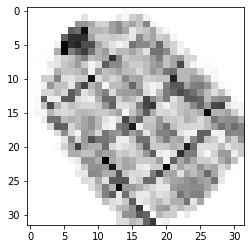

In [59]:
plt.imshow(data_test[7][0].permute((1,2,0)), cmap="Greys")

In [60]:
dataset_sizes = {"train": len(data_train), "val": len(data_test)}
data_loaders = {"train": data_loader_train, "val": data_loader_test}

In [7]:
model = torch.load("models/fmnist_lenet_0dropout_all")
model_dropout = torch.load("models/fmnist_lenet_0.5dropout_all")
model_dropout.load_state_dict(model.state_dict())
model = model_dropout
utils.mc_dropout.set_dropout_p(model, model, .03)
model.feature_extractor[9] = torch.nn.Dropout2d(p=0.03)


model_dropout = torch.load("models/fmnist_lenet_0.5dropout_all")

In [8]:
model

LeNet5_dropout(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): Dropout2d(p=0.03, inplace=False)
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (8): Tanh()
    (9): Dropout2d(p=0.03, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Dropout(p=0.03, inplace=False)
    (2): Tanh()
    (3): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [9]:
model_dropout

LeNet5_dropout(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): Dropout2d(p=0.2, inplace=False)
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (8): Tanh()
    (9): Dropout2d(p=0.2, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Tanh()
    (3): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [10]:
# model = models.mnist.LeNet5_dropout(p_dropout=0).to(device)
# print(model)
# optimizer = torch.optim.Adam(model.parameters())
# criterion = nn.CrossEntropyLoss()
# train_progress = utils.model.train_model(
#     model, 20, optimizer, criterion, data_loaders, device)

In [61]:
utils.mc_dropout.set_dropout_p(model, model, .15)
progress_model= utils.model.run_validation(
    model, data_loaders["val"], utils.metrics.Progress(), device, mc_dropout_iters=5)

progress_model_dropout = utils.model.run_validation(
    model_dropout, data_loaders["val"], utils.metrics.Progress(), device, mc_dropout_iters=5)



Avg. acc.: 26.16: 100%|██████████| 313/313 [00:02<00:00, 146.74it/s]


In [62]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

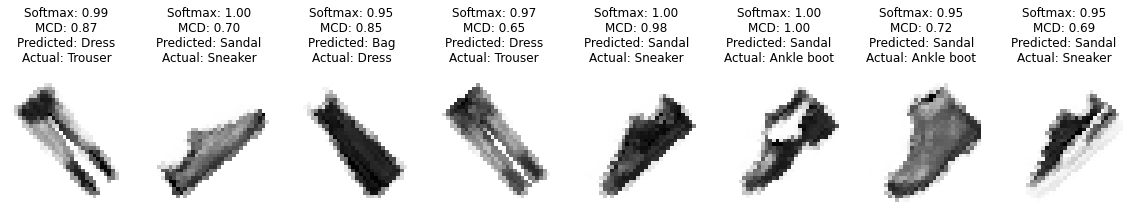

In [65]:
incorrect = np.argwhere((progress_model.predictions != progress_model.labels) & (progress_model.max_probs > .9)).ravel()
# idx = np.argsort(progress_model.max_probs)[::-1][incorrect]
idx=incorrect
num = 8
fig, axs = plt.subplots(1, num, figsize=(20,10))
dropout_max_probs_untrained = progress_model.dropout_outputs.max(axis=-1)

for i in range(num):
    axs[i].imshow(data_test[idx[i]][0].permute(1,2,0), cmap="Greys")
    axs[i].set_title(
        f"Softmax: {progress_model.max_probs[idx[i]]:.2f}\n"
        f"MCD: {dropout_max_probs_untrained[idx[i]]:.2f}\n"
        f"Predicted: {class_names[int(progress_model.predictions[idx[i]])]}\n"
        f"Actual: {class_names[int(progress_model.labels[idx[i]])]}\n"
    )
    axs[i].axis("off")


# progress_model.max_probs[ids]


In [43]:
incorrect.sum()

1111

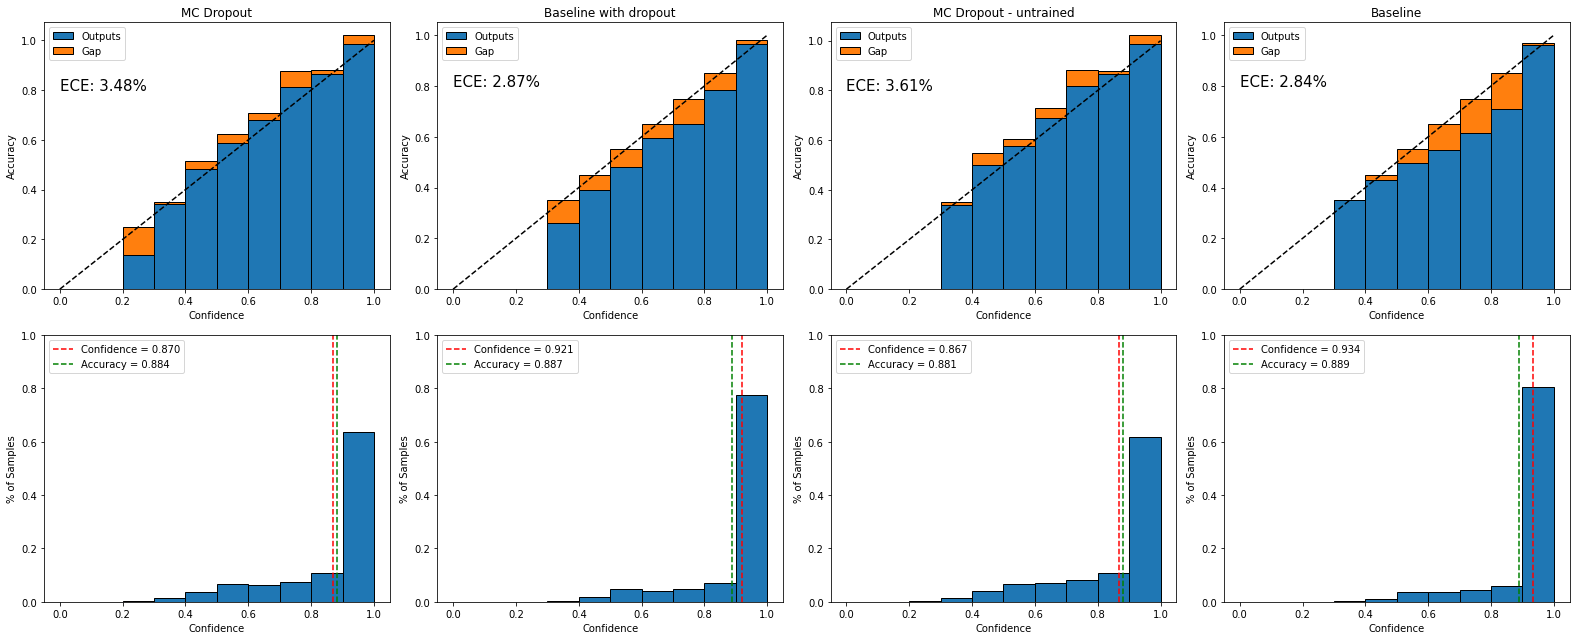

In [12]:
# nll = criterion(torch.tensor(progress.logits), torch.tensor(
#     progress.labels, dtype=torch.long)).item()
# print(
#     f"Accuracy: {(progress.predictions==progress.labels).sum()*100/len(progress.labels):.2f}%, "
#     f"NLL: {nll:4f}"
# )

# mc_logits = progress.dropout_logits.mean(axis=0)
dropout_max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)
dropout_max_probs_untrained = progress_model.dropout_outputs.max(axis=-1)




utils.visualisations.calibration_graph([
        ("MC Dropout", dropout_max_probs, np.argsort(dropout_max_probs), progress_model_dropout.dropout_predictions),
        ("Baseline with dropout", progress_model_dropout.max_probs, np.argsort(progress_model_dropout.max_probs), progress_model_dropout.predictions),
        ("MC Dropout - untrained", dropout_max_probs_untrained, np.argsort(dropout_max_probs_untrained), progress_model.dropout_predictions),
        ("Baseline", progress_model.max_probs, np.argsort(progress_model.max_probs), progress_model.predictions),
    ],
    progress_model_dropout.labels,
    )

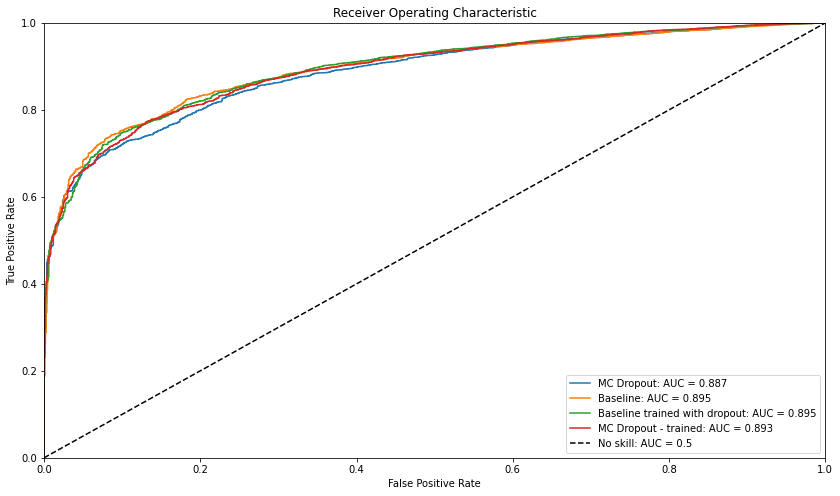

In [13]:
curves = []



correct = progress_model.dropout_predictions == progress_model.labels
max_probs = progress_model.dropout_outputs.max(axis=-1)
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "MC Dropout"))

correct = progress_model.predictions == progress_model.labels
max_probs = progress_model.max_probs
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "Baseline"))

correct = progress_model_dropout.predictions == progress_model.labels
max_probs = progress_model_dropout.max_probs
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "Baseline trained with dropout"))

correct = progress_model_dropout.dropout_predictions == progress_model.labels
max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "MC Dropout - trained"))




plt.figure(figsize=(14,8))
plt.title('Receiver Operating Characteristic')
for curve in curves:
    plt.plot(curve["fpr"], curve["tpr"], label = f"{curve['label']}: AUC = {curve['auroc']:.3f}" )
plt.plot([0, 1], [0, 1],'k--', label=f"No skill: AUC = 0.5")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [62]:
curves = {
    "mcd": utils.metrics.model_metrics(),
    "baseline": utils.metrics.model_metrics(),
    "baseline_dropout": utils.metrics.model_metrics(),
    "mcd_trained":utils.metrics.model_metrics(),
}




for s in np.arange(0, 65, 5):
    transforms= torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((32, 32)),
            torchvision.transforms.RandomRotation(degrees=(s,s)),
            torchvision.transforms.ToTensor(),
        ])

    data_test = torchvision.datasets.FashionMNIST(
        "fmnist", download=True, train=False, transform=transforms)
    data_loader_test = torch.utils.data.DataLoader(data_test,
                                                batch_size=32,
                                                shuffle=False)
    

    print(f"Strength: {s}")
    progress_model = utils.model.run_validation(
        model, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=5)
    progress_model_dropout = utils.model.run_validation(
        model_dropout, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=5)


    # dropout_max_probs = progress_model.dropout_outputs.max(axis=-1)
    # trained_dropout_max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)

    bins = np.linspace(0.05, 0.95, num=10)
    labels = progress_model.labels



    max_probs = progress_model.dropout_outputs.max(axis=-1)
    utils.metrics.update_model_metrics(progress_model, progress_model.dropout_outputs, max_probs, progress_model.dropout_predictions, labels, bins, curves["mcd"], s)
    
    max_probs = progress_model.max_probs
    utils.metrics.update_model_metrics(progress_model, progress_model.probs, max_probs, progress_model.predictions, labels, bins, curves["baseline"], s)

    max_probs = progress_model_dropout.max_probs
    utils.metrics.update_model_metrics(progress_model_dropout, progress_model_dropout.probs, max_probs, progress_model_dropout.predictions, labels, bins, curves["baseline_dropout"], s)

    max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)
    utils.metrics.update_model_metrics(progress_model_dropout, progress_model_dropout.dropout_outputs, max_probs, progress_model_dropout.dropout_predictions, labels, bins, curves["mcd_trained"], s)

Strength: 0


Avg. acc.: 88.75: 100%|██████████| 313/313 [00:02<00:00, 156.13it/s]


Strength: 5


Avg. acc.: 87.33: 100%|██████████| 313/313 [00:02<00:00, 136.58it/s]


Strength: 10


Avg. acc.: 80.07: 100%|██████████| 313/313 [00:02<00:00, 144.70it/s]


Strength: 15


Avg. acc.: 66.41: 100%|██████████| 313/313 [00:02<00:00, 146.22it/s]


Strength: 20


Avg. acc.: 49.27: 100%|██████████| 313/313 [00:02<00:00, 142.06it/s]


Strength: 25


Avg. acc.: 37.48: 100%|██████████| 313/313 [00:02<00:00, 137.98it/s]


Strength: 30


Avg. acc.: 32.91: 100%|██████████| 313/313 [00:02<00:00, 141.51it/s]


Strength: 35


Avg. acc.: 29.23: 100%|██████████| 313/313 [00:02<00:00, 139.55it/s]


Strength: 40


Avg. acc.: 26.16: 100%|██████████| 313/313 [00:02<00:00, 141.67it/s]


Strength: 45


Avg. acc.: 21.44: 100%|██████████| 313/313 [00:02<00:00, 138.67it/s]


Strength: 50


Avg. acc.: 18.39: 100%|██████████| 313/313 [00:02<00:00, 141.63it/s]


Strength: 55


Avg. acc.: 15.20: 100%|██████████| 313/313 [00:02<00:00, 139.13it/s]


Strength: 60


Avg. acc.: 13.16: 100%|██████████| 313/313 [00:02<00:00, 139.80it/s]


In [63]:
import pickle
with open("rotation_fmnist.pickle", "wb") as f:
    pickle.dump(curves,f)

In [ ]:
import pickle
with open("rotation_fmnist.pickle", "rb") as f:
    curves = pickle.load(f)

In [64]:
curves

{'mcd': <utils.metrics.model_metrics at 0x7fb3e13653a0>,
 'baseline': <utils.metrics.model_metrics at 0x7fb3e13653d0>,
 'baseline_dropout': <utils.metrics.model_metrics at 0x7fb3e1365400>,
 'mcd_trained': <utils.metrics.model_metrics at 0x7fb3e1365460>}

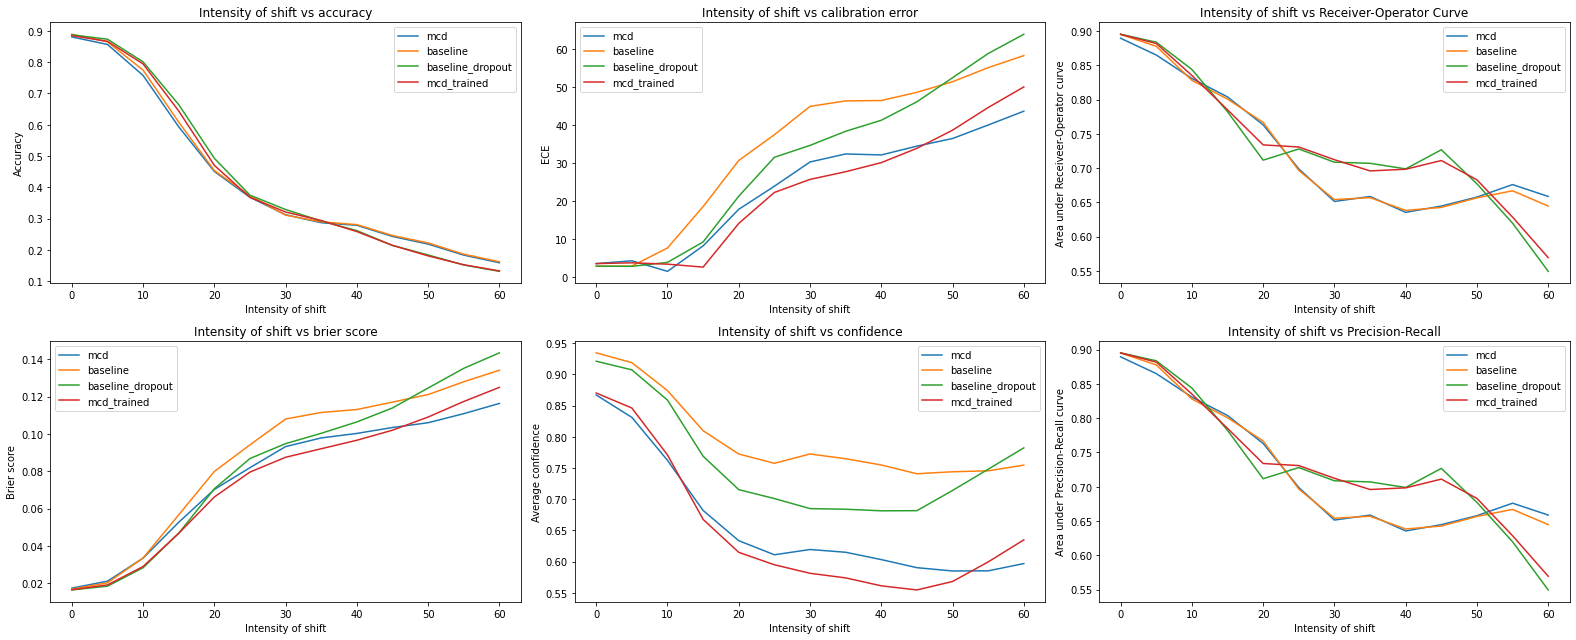

In [65]:
fig, axs = plt.subplots(2, 3, figsize=(22, 9))
for name, m in curves.items():
    ax = axs[0][0]
    ax.plot(m.strengths, m.acc, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs accuracy")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Accuracy")

    ax = axs[1][0]
    ax.plot(m.strengths, m.brier, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs brier score")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Brier score")

    ax = axs[0][1]
    ax.plot(m.strengths, m.ece, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs calibration error")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("ECE")

    ax = axs[1][1]
    ax.plot(m.strengths, m.confs, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs confidence")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Average confidence")

    ax = axs[0][2]
    ax.plot(m.strengths, m.auroc, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs Receiver-Operator Curve")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Area under Receiveer-Operator curve")

    ax = axs[1][2]
    ax.plot(m.strengths, m.auroc, label=name)
    ax.legend()
    ax.set_title("Intensity of shift vs Precision-Recall")
    ax.set_xlabel("Intensity of shift")
    ax.set_ylabel("Area under Precision-Recall curve")
fig.tight_layout()

In [68]:
transforms= torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((32, 32)),
        torchvision.transforms.RandomRotation(degrees=(40,40)),
        torchvision.transforms.ToTensor(),
    ])

data_test = torchvision.datasets.FashionMNIST(
    "fmnist", download=True, train=False, transform=transforms)
data_loader_test = torch.utils.data.DataLoader(data_test,
                                            batch_size=32,
                                            shuffle=False)

progress_model = utils.model.run_validation(
    model, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=5)
progress_model_dropout = utils.model.run_validation(
    model_dropout, data_loader_test, utils.metrics.Progress(), device, mc_dropout_iters=5)




Avg. acc.: 26.16: 100%|██████████| 313/313 [00:02<00:00, 139.94it/s]


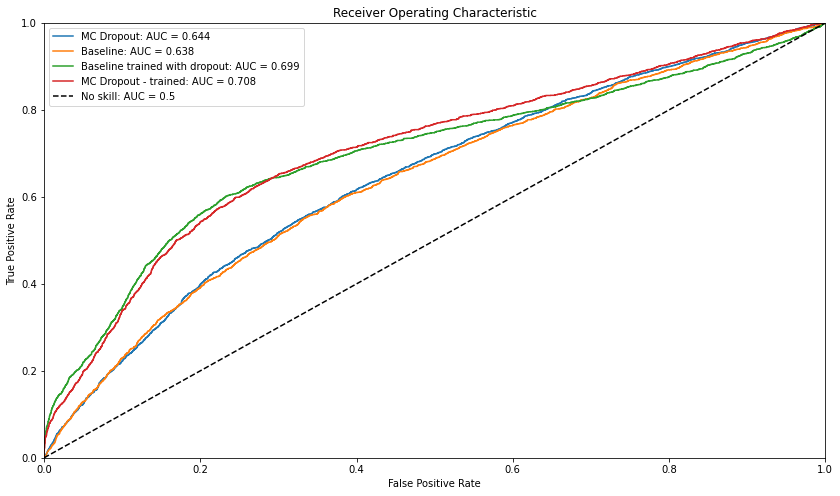

In [70]:
curves = []



correct = progress_model.dropout_predictions == progress_model.labels
max_probs = progress_model.dropout_outputs.max(axis=-1)
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "MC Dropout"))

correct = progress_model.predictions == progress_model.labels
max_probs = progress_model.max_probs
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "Baseline"))

correct = progress_model_dropout.predictions == progress_model.labels
max_probs = progress_model_dropout.max_probs
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "Baseline trained with dropout"))

correct = progress_model_dropout.dropout_predictions == progress_model.labels
max_probs = progress_model_dropout.dropout_outputs.max(axis=-1)
curves.append(utils.metrics.compute_model_stats(correct, max_probs, "MC Dropout - trained"))




plt.figure(figsize=(14,8))
plt.title('Receiver Operating Characteristic')
for curve in curves:
    plt.plot(curve["fpr"], curve["tpr"], label = f"{curve['label']}: AUC = {curve['auroc']:.3f}" )
plt.plot([0, 1], [0, 1],'k--', label=f"No skill: AUC = 0.5")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

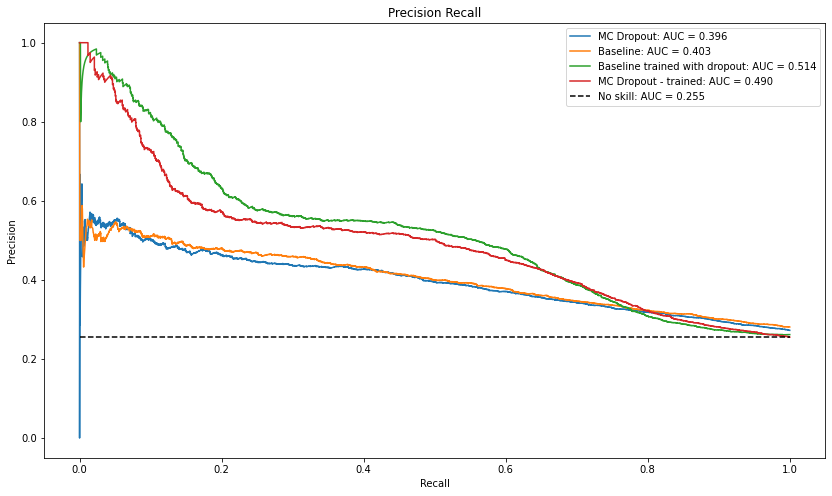

In [71]:
no_skill = correct.sum() / len(correct)
plt.figure(figsize=(14,8))
plt.title('Precision Recall')
for curve in curves:
    plt.plot(curve["recall"], curve["prec"], label=f"{curve['label']}: AUC = {curve['aupr']:.3f}")
# axis labels
plt.plot([0, 1], [no_skill, no_skill], color="k", linestyle='--', label=f'No skill: AUC = {no_skill:.3f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()